FaST-LMM Manual
=====
Factored Spectrally Transformed Linear Mixed Models
========

##### Version 0.2.31
Microsoft Research, January 10, 2017

### Introduction

FaST-LMM, which stands for Factored Spectrally Transformed Linear Mixed Models, is a program for performing both single-SNP and SNP-set genome-wide association studies (GWAS) on extremely large data sets.  This release contains the improvements described in [Widmer et al., Scientific Reports 2014](http://www.nature.com/articles/srep06874), and tests for epistasis. See the FaST-LMM annotated bibliography for additional papers that contributed to the FaST-LMM project and associated code.

For help with the software, please contact [fastlmm@lists.research.microsoft.com](fastlmm@lists.research.microsoft.com).

### Citing FaST-LMM

If you use FaST-LMM in any published work, please cite the relevant manuscript(s) describing it.







 

### Data preparation

This version of FaST-LMM is designed for use with randomly ascertained data with Gaussian residuals.  If you have case-control data with substantial ascertainment bias, you should first transform your phenotype(s) using LEAP (Weissbrod _et al._, _arXiv_ 2014), which is available at https://github.com/omerwe/LEAP.  If you are analyzing continuous phenotypes with non-Gaussian residuals, you should first transform your phenotype(s) using Warped-LMM (Fusi et al., _Nature Commun_ 2014), available at https://github.com/MicrosoftGenomics/WarpedLMM.

FaST-LMM uses four input files containing (1) the SNP data to be tested, (2) the SNP data used to determine the genetic similarity matrix (GSM) between individuals (which can be different from 1), (3) the phenotype data, and (4, optionally) a set of covariates.

SNP files can be in PLINK format (ped/map, tped/tfam, bed/bim/fam, or fam/dat/map).  For the most speed, use the binary format in SNP major order.  See the PLINK manual http://pngu.mgh.harvard.edu/~purcell/plink/ (Purcell et al., _Am J Hum Genet_ 2007) for further details.  FaST-LMM also supports Hdf5 file format http://www.hdfgroup.org/HDF5/whatishdf5.html.  See https://github.com/MicrosoftGenomics/PySnpTools for more details.  Note that each SNP is standardized to have mean zero and standard deviation one across all individuals before processing.  Missing values are mean imputed.

The required file containing the phenotype uses the PLINK alternate phenotype format with no header.  The covariate file also uses this format (with additional columns for multiple covariates).


### Notebook preparation and general use

To prepare this notebook to run analyses, please run the following script.

In [1]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output)
import logging
logging.basicConfig(level=logging.WARNING)

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# set display width for pandas data frames
import pandas as pd
pd.set_option('display.width', 1000)

If you would like to run any of the code below from the command line, first copy it into a file (_e.g._, `test.py`), and then run it by typing `python text.py` at the command line.

If you would like to see all the options for a function just type `? <function_name>` to an ipython prompt.

### Single-SNP association testing



#### Traditional analysis: LMM(all)

First, let's run a standard LMM analysis in which the GSM uses (almost) all available SNPs.  The model for this analysis is called LMM(all) in [Widmer et al., Scientific Reports 2014](http://www.nature.com/articles/srep06874).  We'll apply this model to the synthetic data in `tests\datasets\synth`.  The data has 500 samples with 5000 SNPs, and was generated from a Balding-Nichols model with FST=0.05.

When using a linear mixed model for association analysis, it is important to avoid proximal contamination ([Lippert _et al._, _Nat Meth_ 2011](http://www.nature.com/nmeth/journal/v8/n10/abs/nmeth.1681.html)). To understand proximal contamination, first note that a LMM with no fixed effects, using a realized relationship matrix for the GSM (as FaST-LMM does), is mathematically equivalent to linear regression of the SNPs on the phenotype, with weights integrated over independent Normal distributions having the same variance (_e.g._, Hayes _et al._, _Genet Res_ 2009).  That is, a LMM using a given set of SNPs for the GSM is equivalent to a form of linear regression using those SNPs as covariates to correct for confounding.  This equivalence implies that, when testing a given SNP, that SNP (and SNPs physically close to it) should be excluded from the computation of the GSM.  If not, when testing a particular SNP, we would also be using that same SNP as a covariate, making the log likelihood of the null model higher than it should be, thus leading to deflation of the test statistic and loss of power.

Excluding the SNP you are testing and those SNPs in close proximity to it from the GSM in a naïve way is extremely computationally expensive.  A computationally efficient approach for performing the exclusion is to use a GSM computed from all but chromosome $i$ when testing SNPs on chromosome $i$ ([Lippert _et al._, _Nat Meth_ 2011](http://www.nature.com/nmeth/journal/v8/n10/abs/nmeth.1681.html)).  We call this approach leave out one chromosome (LOOC).  The analysis here does this.


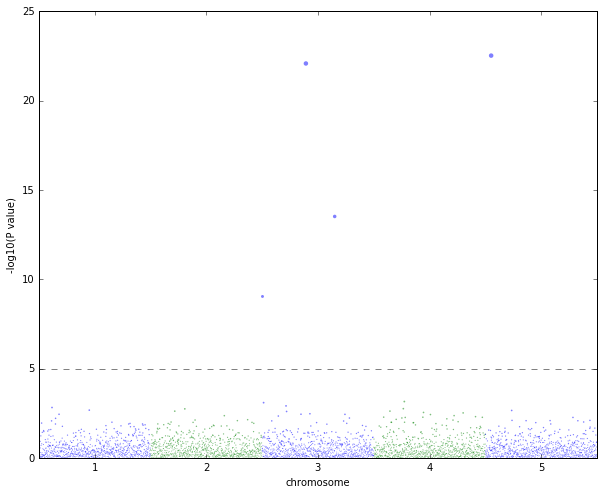

lambda=1.0078


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5,4052,4052,2.990684e-23,-0.418653,0.040052,0.424521,0.0,0.451117
1,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251922e-23,0.416495,0.040300,0.420587,0.0,0.279710
2,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.279710
3,3,snp433_m0_.14m1_.11,3,2003,2003,9.202499e-10,0.268289,0.042973,0.269670,0.0,0.279710
4,274,snp2832_m0_.46m1_.1,4,3274,3274,7.069762e-04,-0.170421,0.050003,0.151124,0.0,0.542046
5,13,snp1413_m0_.04m1_.03,3,2013,2013,8.161238e-04,0.148719,0.044157,0.149377,0.0,0.279710
6,214,snp2804_m0_.16m1_.3,3,2214,2214,1.239806e-03,-0.150705,0.046396,0.144180,0.0,0.279710
7,117,snp751_m0_.04m1_.25,1,117,117,1.527432e-03,0.152430,0.047827,0.141523,0.0,0.614963
8,265,snp1440_m0_.35m1_.32,4,3265,3265,1.771049e-03,-0.136281,0.043358,0.139610,0.0,0.542046
9,307,snp2162_m0_.61m1_.42,2,1307,1307,1.816576e-03,0.143296,0.045700,0.139280,0.0,0.534262


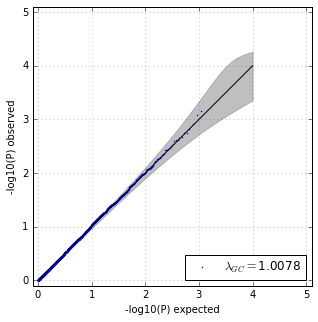

In [3]:
# import the algorithm
from fastlmm.association import single_snp

# set up data
##############################
bed_fn = "../../tests/datasets/synth/all"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# run gwas
###################################################################
results_df = single_snp(bed_fn,  pheno_fn, covar=cov_fn, count_A1=True)

# manhattan plot
import pylab
import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

#### Improving power: LMM(all+select)

In [Widmer et al., Scientific Reports 2014](http://www.nature.com/articles/srep06874), we have shown that power can be increased while still maintaining control of type I error by using two GSMs: one based on all SNPs (`G0`) and one based on selected SNPs that are highly correlated with the phenotype (`G1`).  The model is called LMM(select + all).  This approach has greater computational demands (we recommend using a cluster computer when analyzing large data sets). Here is an example of how to apply this model to the synthetic data.

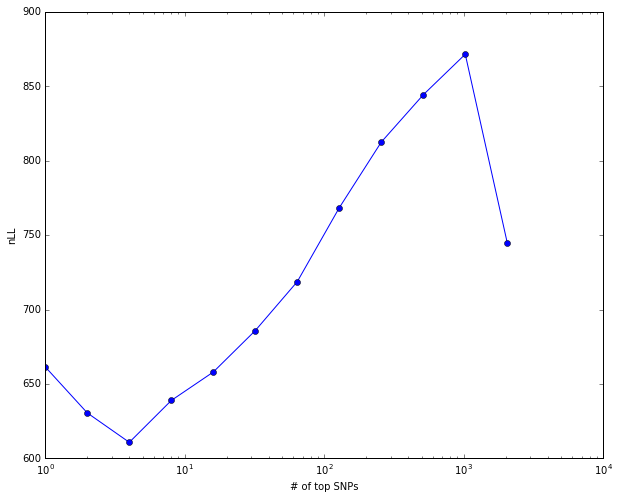

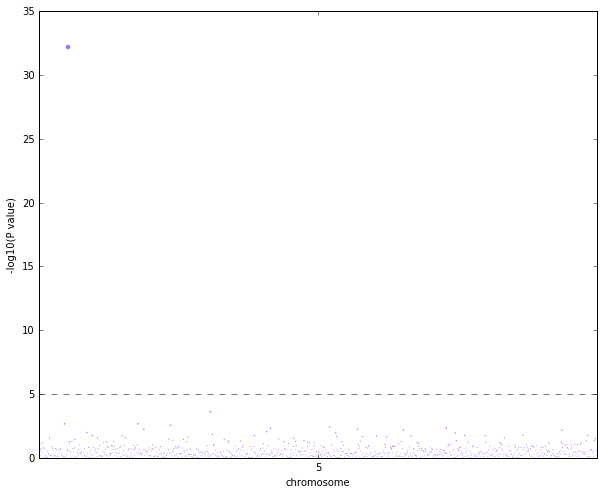

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5,4052,4052,6.246233e-33,-0.395548,0.030731,0.499629,0.688078,0.545958
1,307,snp3970_m0_.53m1_.17,5,4307,4307,2.415292e-04,0.149395,0.040400,0.163479,0.688078,0.545958
2,177,snp3853_m0_.1m1_.04,5,4177,4177,2.162433e-03,-0.109143,0.035401,0.136856,0.688078,0.545958
3,46,snp2743_m0_.03m1_.1,5,4046,4046,2.178166e-03,0.109598,0.035574,0.136760,0.688078,0.545958
4,236,snp726_m0_.28m1_.31,5,4236,4236,2.831892e-03,0.104920,0.034969,0.133250,0.688078,0.545958


In [4]:
# example for two kernel feature selection
# this takes a couple of minutes to run on a 20-proc machine.
from pysnptools.snpreader import Bed
from fastlmm.association import single_snp_all_plus_select

from fastlmm.util.runner import LocalMultiProc
runner = LocalMultiProc(20,mkl_num_threads=5)
    
# define file names
snp_reader = Bed("../../tests/datasets/synth/all", count_A1=True)
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# find the chr5 SNPs
test_snps = snp_reader[:,snp_reader.pos[:,0] == 5]

#select the 2nd kernel and run GWAS
results_df = single_snp_all_plus_select(test_snps=test_snps,G=snp_reader,pheno=pheno_fn,GB_goal=2,do_plot=True,runner=runner)

import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

results_df.head()

Aside: In some applications, you may want to use two kernels constructed from two pre-specified sets of SNPs (i.e., with no feature selection). Here we show how to do that and how to simultaneously find h2 and the mixing weight between the kernels.

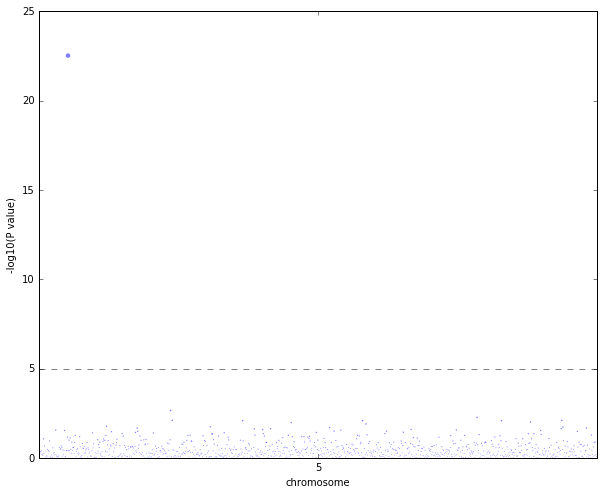

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5,4052,4052,2.990684e-23,-0.418653,0.040052,0.424521,0.0,0.451117
1,236,snp726_m0_.28m1_.31,5,4236,4236,2.229561e-03,0.133405,0.043400,0.136587,0.0,0.451117
2,785,snp4608_m0_.35m1_.39,5,4785,4785,5.489019e-03,0.122558,0.043942,0.124139,0.0,0.451117
3,239,snp2615_m0_.49m1_.25,5,4239,4239,8.029457e-03,-0.123956,0.046572,0.118546,0.0,0.451117
4,937,snp1115_m0_.1m1_.1,5,4937,4937,8.030123e-03,0.116014,0.043589,0.118545,0.0,0.451117


In [5]:
# example script for two kernel without feature selection
import numpy as np
import pysnptools.util
from pysnptools.snpreader import Bed
from fastlmm.association import single_snp

# define file names
bed_fn = "../../tests/datasets/synth/all"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# select data
###################################################################
snp_reader = Bed(bed_fn,count_A1=True)

# partition snps on chr6 vs rest
G1_chr = 6
G0 = snp_reader[:,snp_reader.pos[:,0] != G1_chr]
G1 = snp_reader[:,snp_reader.pos[:,0] == G1_chr]

# test on chr5
test_snps = snp_reader[:,snp_reader.pos[:,0] == 5]

results_df = single_snp(test_snps, pheno_fn, K0=G0, K1=G1, covar=cov_fn, GB_goal=2, count_A1=True)


import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()
results_df.head()

#### Improving speed and memory use when there is little family strucutre: LMM(select)+PCs

In the same publication, we have shown that a simpler, more computationally efficient model can be used when the data is  confounded only by population structure and not by family structure or cryptic relatedness.  Under these circumstances, we have found that a model with a single GSM based on selected SNPs in combination with principle components as fixed-effect covariates yields good control of type I error and power.  

This model, called LMM(select)+PCs, should be used with caution.  Even if you explicitly remove closely related individuals from your data, cryptic relatedness may remain.

To use this model, first identify the principle components to be used with the PCgeno algorithm as described in [Widmer et al., Scientific Reports 2014](http://www.nature.com/articles/srep06874). 

Then you can call single_snp_select with these PCs as covariates.

selected number of PCs: 1


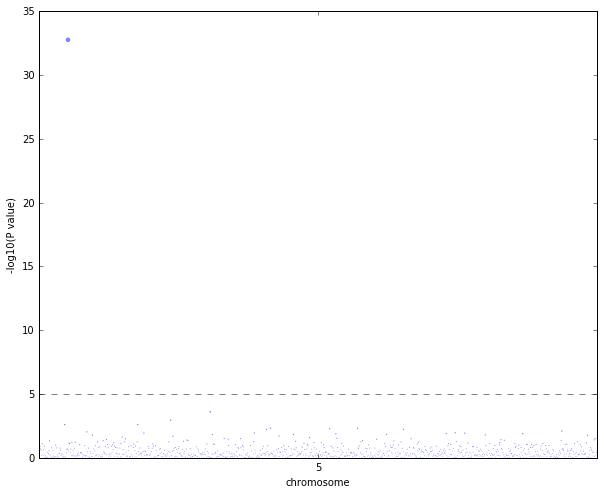

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5,4052,4052,1.679173e-33,-0.401931,0.030898,0.503978,0.0,0.374751
1,307,snp3970_m0_.53m1_.17,5,4307,4307,2.492670e-04,0.153034,0.041475,0.163287,0.0,0.374751
2,236,snp726_m0_.28m1_.31,5,4236,4236,1.132823e-03,0.115687,0.035331,0.145316,0.0,0.374751
3,177,snp3853_m0_.1m1_.04,5,4177,4177,2.461932e-03,-0.108263,0.035571,0.135267,0.0,0.374751
4,46,snp2743_m0_.03m1_.1,5,4046,4046,2.504740e-03,0.109775,0.036131,0.135036,0.0,0.374751


In [6]:
from pysnptools.snpreader import Bed
from fastlmm.util import compute_auto_pcs
from fastlmm.association import single_snp_select

# define file names
bed_fn = "../../tests/datasets/synth/all"
snp_reader = Bed(bed_fn,count_A1=True)
phen_fn = "../../tests/datasets/synth/pheno_10_causals.txt"

# find number of PCs
pcs = compute_auto_pcs(bed_fn,count_A1=True)
print "selected number of PCs:", pcs["vals"].shape[1]

# test on chr5
test_snps = snp_reader[:,snp_reader.pos[:,0] == 5]

results_df = single_snp_select(test_snps=test_snps, G=snp_reader, pheno=phen_fn, covar=pcs, GB_goal=2)


import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

results_df.head()

### Epistasis

You can test for epistatic interactions between pairs of SNPs as well.  Here is an example analysis applied to the same synthetic data.  Note that this version of the code uses a likelihood ratio test based on maximum-likelihood estimates.  A REML-based version is in the works.

lambda=0.9234


,SNP0,Chr0,GenDist0,ChrPos0,SNP1,Chr1,GenDist1,ChrPos1,PValue,NullLogLike,AltLogLike
0,snp1754_m0_.19m1_.42,1.0,38.0,38.0,snp2376_m0_.38m1_.49,1.0,20.0,20.0,0.000451,-700.878718,-694.724583
1,snp625_m0_.03m1_.07,1.0,0.0,0.0,snp3000_m0_.28m1_.34,1.0,5.0,5.0,0.001306,-700.387891,-695.220652
2,snp250_m0_.23m1_.19,1.0,15.0,15.0,snp2377_m0_.06m1_.02,1.0,30.0,30.0,0.002279,-698.768488,-694.113511
3,snp376_m0_.17m1_.17,1.0,9.0,9.0,snp625_m0_.03m1_.07,1.0,0.0,0.0,0.002287,-700.206861,-695.555229
4,snp125_m0_.64m1_.41,1.0,21.0,21.0,snp1754_m0_.19m1_.42,1.0,38.0,38.0,0.002404,-700.873862,-696.267594
5,snp2878_m0_.82m1_.58,1.0,42.0,42.0,snp1878_m0_.58m1_.36,1.0,48.0,48.0,0.002568,-698.579519,-694.033792
6,snp1128_m0_.14m1_.13,1.0,35.0,35.0,snp1625_m0_.4m1_.47,1.0,23.0,23.0,0.003067,-700.445456,-696.061998
7,snp3_m0_.55m1_.46,1.0,32.0,32.0,snp1753_m0_.17m1_.19,1.0,28.0,28.0,0.004327,-700.735073,-696.664365
8,snp250_m0_.23m1_.19,1.0,15.0,15.0,snp3_m0_.55m1_.46,1.0,32.0,32.0,0.004486,-700.927439,-696.889564
9,snp1753_m0_.17m1_.19,1.0,28.0,28.0,snp251_m0_.1m1_.49,1.0,33.0,33.0,0.006503,-700.728933,-697.026244


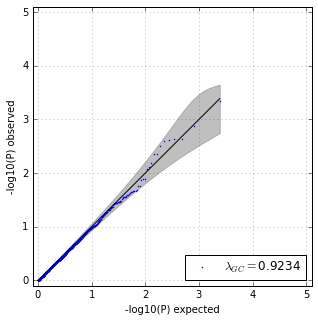

In [7]:
# import the algorithm and reader
from fastlmm.association import epistasis
from pysnptools.snpreader import Bed

# define file names
bed_reader = Bed("../../tests/datasets/synth/all", count_A1=True)
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# partition data into the first 50 SNPs on chr1 and all but chr1
G0 = bed_reader[:,bed_reader.pos[:,0] != 1]
test_snps = bed_reader[:,bed_reader.pos[:,0] == 1][:,0:50]

# run epistasis analysis
results_df = epistasis(test_snps, pheno_fn, G0=G0, covar=cov_fn)

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
pd.set_option('display.width', 1000)
results_df.head(n=10)

### SNP-set association testing

SNP-set association testing is performed similarly to single-SNP testing, except we test sets of SNPs by putting them together into one GSM, separate from any (optional) background GSM that corrects for confounding.  Both LRT ("lrt") and score ("sc_davies") tests are supported.  The LRT is computed by default, but you can switch to the score test by setting test=“sc_davies”.  The score test can be more conservative in some settings (and hence can have less power), but it is closed form and often can be computed much faster.  The algorithms in their current form are described in [Lippert et al., Bioinformatics 2014](http://bioinformatics.oxfordjournals.org/content/30/22/3206).

Here is an example that uses the LRT and no background GSM--note the inflation in the results.

,SetId,LogLikeAlt,LogLikeNull,P-value,#SNPs_in_Set,#ExcludedSNPs,chrm,pos. range,Alt_h2,Alt_a2
0,set_65,-703.888501,-707.609745,0.002564,10,0,1,650-659,0.029725,0.0
1,set_86,-704.240753,-707.609745,0.003768,10,0,1,860-869,0.030321,0.0
2,set_70,-704.525274,-707.609745,0.005158,10,0,1,700-709,0.029790,0.0
3,set_18,-704.920236,-707.609745,0.008020,10,0,1,180-189,0.024803,0.0
4,set_45,-705.410762,-707.609745,0.014031,10,0,1,450-459,0.023440,0.0
5,set_84,-705.507312,-707.609745,0.015693,10,0,1,840-849,0.024002,0.0
6,set_98,-705.623163,-707.609745,0.017965,10,0,1,980-989,0.022271,0.0
7,set_80,-705.728130,-707.609745,0.020327,10,0,1,800-809,0.023943,0.0
8,set_73,-706.000699,-707.609745,0.028153,10,0,1,730-739,0.019835,0.0
9,set_92,-706.166636,-707.609745,0.034473,10,0,1,920-929,0.019799,0.0


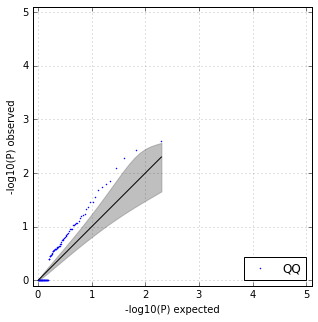

In [8]:
# this will take a few minutes to run

# import the algorithm and reader
from fastlmm.association import snp_set
from pysnptools.snpreader import Bed
import datetime

# define file names
test_snps_fn = "../../tests/datasets/synth/chr1"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"
set_list_fn = "../../tests/datasets/synth/chr1.sets.txt"
G0_fn = None

# run SNP-set analysis
results_df = snp_set(test_snps=test_snps_fn, G0=G0_fn, set_list=set_list_fn, pheno=pheno_fn, covar=cov_fn, test="lrt")

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["P-value"].values, xlim=[0,5], ylim=[0,5], addlambda=False, legend="QQ")

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

As just mentioned, we see inflation of the test statistic because no background GSM was used. When you include a background GSM (using `G0`) type I error is better controlled. As in the single SNP case, proximal contamination is avoided using LOOC.

constructing LMM - this should only happen once.


,SetId,LogLikeAlt,LogLikeNull,P-value,#SNPs_in_Set,#ExcludedSNPs,chrm,pos. range,Alt_h2,Alt_h2_1
0,set_60,-697.449026,-699.619196,0.016062,10,0,1,600-609,0.630039,0.024977
1,set_11,-697.979257,-699.619196,0.028124,10,0,1,110-119,0.618464,0.022458
2,set_14,-698.359356,-699.619196,0.042932,10,0,1,140-149,0.623297,0.019099
3,set_80,-698.401148,-699.619196,0.045045,10,0,1,800-809,0.619344,0.017966
4,set_70,-698.430620,-699.619196,0.046607,10,0,1,700-709,0.577376,0.017370
5,set_45,-698.442867,-699.619196,0.047275,10,0,1,450-459,0.592120,0.015451
6,set_86,-698.518404,-699.619196,0.051648,10,0,1,860-869,0.592057,0.017528
7,set_92,-698.547797,-699.619196,0.053477,10,0,1,920-929,0.621042,0.017506
8,set_65,-698.714102,-699.619196,0.065409,10,0,1,650-659,0.584255,0.016500
9,set_93,-698.820185,-699.619196,0.074734,10,0,1,930-939,0.618306,0.012515


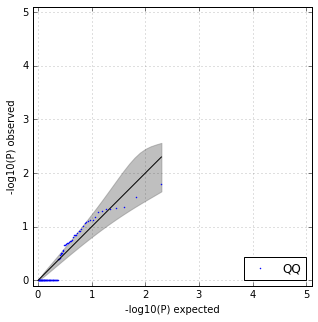

In [11]:
#Here we give a G0, the GSM, created via Bed file with all the chroms except chrom 1 (the test snps)

#WARNING: Even on a fast machine, this takes 24 minutes (but, running with test="sc_davies" takes seconds)

bed_reader = Bed("../../tests/datasets/synth/all.bed",count_A1=True)
chrNot1 = bed_reader[:,bed_reader.pos[:,0] != 1]
G0_fn = "../../tests/datasets/synth/chrNot1.bed"
Bed.write(G0_fn,chrNot1.read(),count_A1=True)

# run SNP-set analysis
results_df = snp_set(test_snps=test_snps_fn, G0=G0_fn, set_list=set_list_fn, pheno=pheno_fn, covar=cov_fn, test="lrt")

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["P-value"].values, xlim=[0,5], ylim=[0,5], addlambda=False, legend="QQ")

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

The `G1` option available for single-marker testing is not yet supported for set testing. With the same caveats as previously described, however, you can use PC covariates and a `G0` based on selected SNPs when your data is confounded, for example, by population structure.

### Prediction

We can train on one set of examples and make predictions on another set.

Predicted means and stdevs
[-0.01441868 -0.28643402 -0.25428547  0.08895202 -0.29511009 -0.39238037
  0.06844377 -0.43282081 -0.21734717 -0.3552239 ]
[ 0.95795615  0.96181176  0.95260425  0.9499153   0.9604778   0.95411448
  0.96020393  0.9817148   0.95198988  0.96271045]


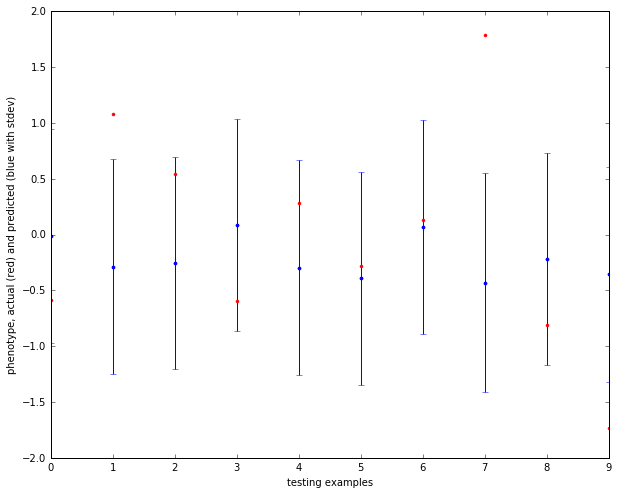

In [12]:
from pysnptools.snpreader import Pheno, Bed
from fastlmm.inference import FastLMM
import numpy as np

# define file names
snp_reader = Bed("../../tests/datasets/synth/all",count_A1=True)
cov_fn = "../../tests/datasets/synth/cov.txt"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"

# Divide the data into train (all but the last 10 individuals) and test (the last 10 individuals)
# (the cov and pheno will automatially be divided to match)
train = snp_reader[:-10,:]
test = snp_reader[-10:,:]

# In the style of scikit-learn, create a predictor and then train it.
fastlmm = FastLMM(GB_goal=2)
fastlmm.fit(K0_train=train,X=cov_fn,y=pheno_fn)

# Now predict with it
mean, covariance = fastlmm.predict(K0_whole_test=test,X=cov_fn)

print "Predicted means and stdevs"
print mean.val[:,0]
print np.sqrt(np.diag(covariance.val))

#Plot actual phenotype and predicted phenotype
whole_pheno = Pheno(pheno_fn)
actual_pheno = whole_pheno[whole_pheno.iid_to_index(mean.iid),:].read()
pylab.plot(actual_pheno.val,"r.")
pylab.plot(mean.val,"b.")
pylab.errorbar(np.arange(mean.iid_count),mean.val,yerr=np.sqrt(np.diag(covariance.val)),fmt='.')
pylab.xlabel('testing examples')
pylab.ylabel('phenotype, actual (red) and predicted (blue with stdev)')
pylab.show()

### Appendix

Columns in the output are as follows:

`SNP` or `Set`
The SNP or set identifier tested.

`PValue`
The _P_ value computed for the SNP tested.

`NullLogLike`
The log likelihood of the null model.

`AltLogLike`
The log likelihood of the alternative model.

Global statistics, such as sample size and the number of SNPs tested are printed to stdout at the end of the run.

###### Single-SNP testing only:

`Chr`
The chromosome identifier for the SNP tested or 0 if unplaced.  Taken from the PLINK file.

`GenDist`
The genetic distance of the SNP on the chromosome.  Taken from the PLINK file.  Any units are allowed, but typically centimorgans or morgans are used.

`ChrPos`
The base-pair position of the SNP on the chromosome (bp units).  Taken from the PLINK file.

`SnpWeight`
The fixed-effect weight of the SNP.

`SnpWeightSE`
The standard error of the SnpWeight.

`Nullh2`
The narrow sense heritability given by h2 $=σ_g^2/(σ_g^2+σ_e^2)$ on the null model.

###### SNP-set testing only:

`#SNPs_in_Set`
The number of markers in the set.

`Alt_h2`
The value found in the alt. model, given by $\sigma^2(h2(a2*K_S+(1-a2) * K_C)+(1-h2)*I)$, where $K_C$ is the NxN matrix to correct for confounding, and $K_S$ is the matrix containing SNPs to be tested.	

`Alt_a2`
See Alt_h2.

`Null_h2`
The value found in the null model, given by $\sigma^2(h2*K_C+1-h2)*I)$, where $K_C$ is the $N \times N$ matrix to correct for confounding.
